# Análise Exploratória do Corpus 'Viés'

Esta análise tem como objetivo verificar o balanceamento do corpus em relação às entides abordadas, aos sentimentos atribuídos e aos veículos utilizados.

## Realizando análises exploratórias preliminares
O corpus se encontra armazenado num banco de dados MySQL, no banco CORPUS_VIES, tabelas PARAGRAPHS e NEWS

In [4]:
%matplotlib notebook

import pymysql, traceback
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1.0*height, '%d'%int(height),
                ha='center', va='bottom')
        
def plotResultsInBarChart():
    pass

### Distribuição das entidades
Consulta a tabela PARAGRAPHS para cada entidade. Essa análise serve para avaliar como esse dataset está balanceado em relação aos candidatos a presidencia e ao governo de SP. Por enquanto, vou fazer somente a análise dos candidatos a presidência. Os resultados serão exibidos num gráficos de barras.

#### Consulta no banco de dados

In [5]:
presidencialCandidates = ['dilma', 'aécio neves', 'marina', 'eduardo campos', 'luciana genro']
queryResults = defaultdict(lambda: (int, []))
sqlQueryModel = 'SELECT TEXT_SOURCE, POLARITY FROM PARAGRAPHS WHERE ENTITY = "{}"'

db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
cursor = db.cursor()

for candidate in presidencialCandidates:
    sql = sqlQueryModel.format(candidate)
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        rowCount = cursor.rowcount
        queryResults[candidate] = (rowCount, results)
        
    except:
        print(traceback.format_exc())        
db.close()

#### Exibição das contagens num gráfico - Candidato x frequencia

<IPython.core.display.Javascript object>


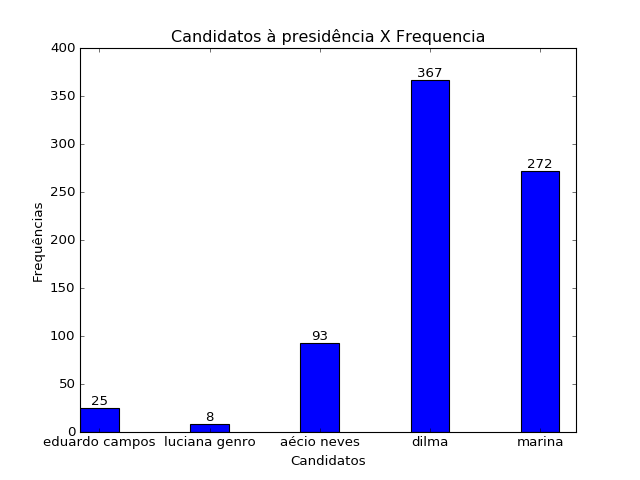

In [21]:
values = list(count for count, register in queryResults.values())
xlabels = list(queryResults.keys())
indices = np.arange(len(xlabels))

f1 = plt.figure()
ax1 = f1.add_subplot(111)

barWidth = 0.35
p = ax1.bar(indices, values, barWidth, tick_label = values)
plt.ylabel('Frequências')
plt.xlabel('Candidatos')
plt.title('Candidatos à presidência X Frequencia')
plt.xticks(indices + barWidth/2., xlabels)
autolabel(p)

plt.show()

### Distribuição das polaridades pelos candidatos

<IPython.core.display.Javascript object>


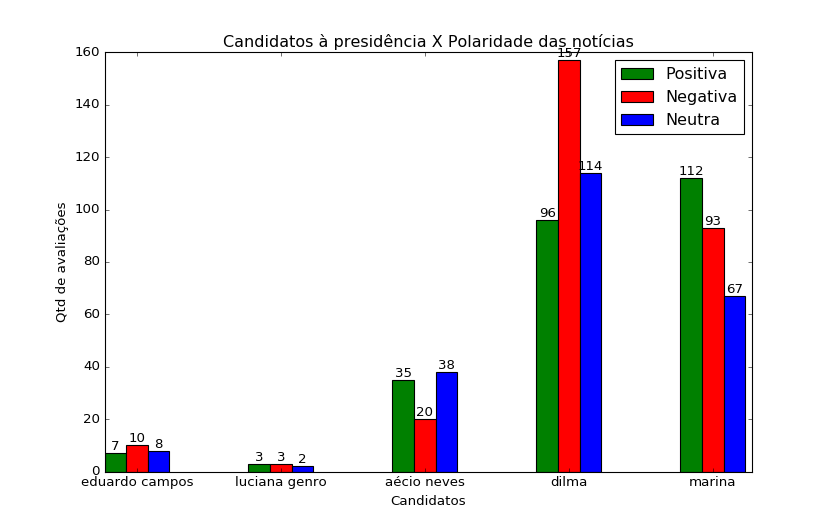

In [23]:
def countByPolarity(results):
    p = {'PO':0, 'NG':0, 'NE': 0}
    for polarity in results:
        p[polarity] += 1
    return p

def plotPolarityBar(ax, indices, polarityValues, color, offset):
    width=0.15
    p = ax.bar(indices + offset*width, polarityValues, width, color = color)
    return p

candidatesPolarities = defaultdict(lambda: {})
for candidate in presidencialCandidates:
    polarityList = [line[1] for line in queryResults[candidate][1]]
    candidatesPolarities[candidate] = countByPolarity(polarityList)
    
indices = np.arange(len(candidatesPolarities.keys()))

positiveValues = [candidatesPolarities[candidate]['PO'] for candidate in candidatesPolarities.keys()]
negativeValues = [candidatesPolarities[candidate]['NG'] for candidate in candidatesPolarities.keys()]
neutralValues = [candidatesPolarities[candidate]['NE'] for candidate in candidatesPolarities.keys()]

f2 = plt.figure()
ax2 = f2.add_subplot(111)

posivite_plot = plotPolarityBar(ax2, indices, positiveValues, 'g', offset = 0)
negative_plot = plotPolarityBar(ax2, indices, negativeValues, 'r', offset = 1)
neutral_plot =  plotPolarityBar(ax2, indices, neutralValues, 'b', offset = 2)

plt.ylabel('Qtd de avaliações')
plt.xlabel('Candidatos')
plt.title('Candidatos à presidência X Polaridade das notícias')
barWidth = 0.15
plt.xticks(indices + 3*barWidth/2., list(candidatesPolarities.keys()))
plt.legend((posivite_plot[0], negative_plot[0], neutral_plot[0]), ('Positiva', 'Negativa', 'Neutra'))

autolabel(posivite_plot)
autolabel(negative_plot)
autolabel(neutral_plot)

df = pd.DataFrame(candidatesPolarities)
df = df.transpose()
df

plt.show()

### Distribuição de veículos

In [24]:
textSources = ['@g1politica', '@folha_poder', '@VEJA', '@cartacapital', '@EstadaoPolitica']

sqlQuery = 'SELECT POLARITY FROM PARAGRAPHS WHERE TEXT_SOURCE = "{}"'
db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
cursor = db.cursor()

sourceCount = pd.DataFrame(index = textSources, columns = ['count'])


for source in textSources:
    sql = sqlQuery.format(source)
    try:
        cursor.execute(sql)
        count = cursor.rowcount
        results = cursor.fetchall()
        results = [value for value in results if value[0] != '']
        sourceCount.set_value(source, 'count', len(results))
    except:
        print(traceback.format_exc())
        
db.close()
        
sourceCount

,count
@g1politica,218
@folha_poder,596
@VEJA,114
@cartacapital,76
@EstadaoPolitica,38


### Distribuição de polaridades por candidatos e por fonte

In [26]:
from itertools import product

polarities = ['NG', 'PO', 'NE']
textSources = ['@g1politica', '@folha_poder', '@VEJA', '@cartacapital', '@EstadaoPolitica']
presidencialCandidates = ['dilma', 'aécio neves', 'marina', 'eduardo campos', 'luciana genro']

sqlQuery = 'SELECT * FROM PARAGRAPHS WHERE TEXT_SOURCE = "{}" AND ENTITY = "{}" AND POLARITY = "{}"'

db = pymysql.connect('localhost', 'root', '12345', 'CORPUS_VIES')
cursor = db.cursor()

resultDF = pd.DataFrame(index= product(presidencialCandidates, polarities), columns = textSources)

for source, entity, polarity in product(textSources, presidencialCandidates, polarities):
    sql = sqlQuery.format(*(source, entity, polarity))
    try:
        cursor.execute(sql)
        count = cursor.rowcount
        
        resultDF.set_value((entity, polarity), source, count)
    except:
        print(traceback.format_exc())
        
db.close()

resultDF

,@g1politica,@folha_poder,@VEJA,@cartacapital,@EstadaoPolitica
"(dilma, NG)",33,71,32,9,12
"(dilma, PO)",21,64,1,9,1
"(dilma, NE)",39,50,6,15,4
"(aécio neves, NG)",3,17,0,0,0
"(aécio neves, PO)",5,24,3,0,3
"(aécio neves, NE)",3,27,5,0,3
"(marina, NG)",9,54,22,6,2
"(marina, PO)",23,62,15,7,5
"(marina, NE)",14,37,8,7,1
"(eduardo campos, NG)",1,5,4,0,0
